<a href="https://colab.research.google.com/github/Shivdutta/AdvanceCNN/blob/master/CiFAR10_Fashion_classification_resnet50_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
#from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths


Using TensorFlow backend.


In [3]:
tf.__version__

'2.2.0-rc3'

In [9]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!unzip -q "/content/gdrive/My Drive/CNN_Images/VGG_class_data.zip"

Mounted at /content/gdrive/
replace data/test/backpack/00000010.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [12]:
!ls /content/data

test  train


In [0]:
#Give dataset path
trainpath = "/content/data/train"
testpath = "/content/data/test"
classes = 4
Image_Size =128
batch_size=20

INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 20
# define the path to the serialized output model after training
MODEL_PATH = "fashion_resnet.model"


In [4]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


94773248/94765736 [==============================] - 1s 0us/step


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!unzip -q "/content/gdrive/My Drive/CNN_Images/VGG_class_data.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
%ls /content/data/

test/  train/


In [0]:
#baseModel.summary()

In [0]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [22]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	testpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	testpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 475 images belonging to 4 classes.
Found 264 images belonging to 4 classes.
Found 264 images belonging to 4 classes.


In [23]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

[INFO] preparing model...


In [27]:
# compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
H = model.fit_generator(
	trainGen,
	steps_per_epoch=len(list(paths.list_files(trainpath))) // BS,
	validation_data=valGen,
	validation_steps=len(list(paths.list_files(testpath))) // BS,
	epochs=NUM_EPOCHS)

[INFO] training model...
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/20
14/14 [==============================] - 16s 1s/step - loss: 0.6181 - accuracy: 0.4353 - val_loss: 0.2877 - val_accuracy: 0.7695
Epoch 2/20
14/14 [==============================] - 16s 1s/step - loss: 0.3124 - accuracy: 0.7088 - val_loss: 0.1471 - val_accuracy: 0.9297
Epoch 3/20
14/14 [==============================] - 16s 1s/step - loss: 0.1738 - accuracy: 0.8578 - val_loss: 0.0939 - val_accuracy: 0.9609
Epoch 4/20
14/14 [==============================] - 16s 1s/step - loss: 0.1113 - accuracy: 0.9165 - val_loss: 0.0717 - val_accuracy: 0.9609
Epoch 5/20
14/14 [==============================] - 17s 1s/step - loss: 0.0918 - accuracy: 0.9278 - val_loss: 0.0657 - val_accuracy: 0.9648
Epoch 6/20
14/14 [==============================] - 16s 1s/step - loss: 0.0892 - accuracy: 0.9300 - val_loss: 0.0530 - val_accuracy: 0.9648
Epoch 7/20
14/14 [==============================] - 17s 1s/step - loss: 0.0620 - accuracy: 0.9526 - val_loss: 0.0494 - val_accuracy: 0.9688
Epoch 8/20
14/14 [==

In [30]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,	steps=(len(list(paths.list_files(testpath))) // BS) + 1)
predIdxs

[INFO] evaluating network...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[9.9991500e-01, 7.9214105e-06, 1.9859346e-05, 5.7301353e-05],
       [9.9874395e-01, 4.0965947e-06, 1.9369242e-04, 1.0583905e-03],
       [9.9716115e-01, 2.9229256e-04, 1.6245105e-04, 2.3841052e-03],
       ...,
       [1.2710016e-02, 2.0468456e-03, 3.6163307e-03, 9.8162675e-01],
       [5.2102428e-06, 3.7475405e-04, 9.4299985e-06, 9.9961060e-01],
       [1.3053449e-05, 1.4790909e-06, 2.7253518e-06, 9.9998271e-01]],
      dtype=float32)

In [31]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
predIdxs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3])

In [32]:
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

              precision    recall  f1-score   support

    backpack       0.98      0.98      0.98        66
    footwear       0.97      0.98      0.98        66
     glasses       1.00      0.95      0.98        66
       watch       0.96      0.98      0.97        66

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264

[INFO] saving model...


In [0]:
model_loaded = tf.keras.models.load_model(MODEL_PATH)

In [34]:
!pwd

/content


In [36]:
!ls /content/data/test/backpack

00000010.png  00000269.png  00000335.jpg  00000350.jpg	00000368.jpg
00000018.png  00000270.png  00000336.jpg  00000351.jpg	00000370.png
00000027.png  00000275.png  00000337.jpg  00000352.jpg	00000371.jpg
00000053.png  00000324.jpg  00000338.jpg  00000353.jpg	00000372.jpg
00000069.png  00000325.jpg  00000340.jpg  00000354.jpg	00000374.jpg
00000131.png  00000326.jpg  00000341.png  00000355.jpg	00000375.jpg
00000137.png  00000327.jpg  00000342.jpg  00000356.jpg	00000376.jpg
00000198.png  00000328.jpg  00000343.jpg  00000357.jpg	00000377.jpg
00000199.png  00000329.png  00000344.jpg  00000359.jpg	00000378.jpg
00000208.png  00000330.png  00000345.jpg  00000360.jpg	00000379.jpg
00000214.png  00000331.jpg  00000346.jpg  00000361.jpg
00000217.png  00000332.jpg  00000347.jpg  00000362.jpg
00000245.png  00000333.jpg  00000348.jpg  00000363.jpg
00000267.png  00000334.jpg  00000349.jpg  00000366.jpg


Input Dimensions - Image :  (128, 128, 3)


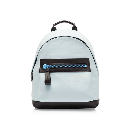

In [37]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img= "/content/data/test/backpack/00000359.jpg"
input_img = io.imread(input_img)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
cv2_imshow(input_img)

In [0]:
img_path = input_img
